### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов. 

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на github с проектом - 

Ноутбук с результатами выкладывать на ваш **google диск** курса. 

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский. 

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. 

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой. 
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позицонных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate schedualer


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количетсво слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [ ]:
# !wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
# !pip install tokenizers

In [13]:
import sys
sys.path.insert(0, '/ssd/r.musaev/DL_sber_hw/pytorch-machine-translation/src')

In [20]:
import torch
import numpy as np
import random
import torch.nn as nn
import yaml
from src.data.datamodule import DataManager
from src.txt_logger import TXTLogger
%reload_ext autoreload
%autoreload 2
from src.models.seq2seq_transformer import Seq2SeqTransformer
from src.models import trainer

## fix seed and define boilerplate

In [21]:
def seed_everything(seed: int):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger = TXTLogger("baseline")

## prepare data

In [22]:
with open("configs/data_config.yaml", "r") as fread:
    data_config = yaml.load(fread, Loader=yaml.Loader)

data_manager = DataManager(data_config, device)
train_dataloader, val_dataloader = data_manager.prepare_data()
target_tokenizer = data_manager.target_tokenizer


Reading from file: 100%|██████████| 467119/467119 [00:05<00:00, 85871.07it/s]


## prepare model

In [23]:
with open("configs/model_config.yaml", "r") as fread:
    model_config = yaml.load(fread, Loader=yaml.Loader)

model_config["src_vocab_size"] = data_manager.source_tokenizer.tokenizer.get_vocab_size()
model_config["tgt_vocab_size"] = data_manager.target_tokenizer.tokenizer.get_vocab_size()
model_config["T_max"] = model_config["epoch_num"] * len(train_dataloader)
model_config["device"] = device 

print(model_config["tgt_vocab_size"], model_config["src_vocab_size"])

model = Seq2SeqTransformer(model_config, target_tokenizer.word2index).to(device)

4313 2703


In [24]:
trainer_cls = trainer.Trainer(
    model=model,
    model_config=model_config,
    logger=logger,
    target_tokenizer=target_tokenizer
)

trainer_cls.train(train_dataloader, val_dataloader)

 17%|█▋        | 101/600 [02:02<10:07,  1.22s/it]

Last 101 epoch train loss:  0.016536186449229717
Last 101 epoch val loss:  2.2404410243034363
Last 101 epoch val bleu:  0.0


## plot training progress

/ssd/r.musaev/python/miniconda3/envs/new_base/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/ssd/r.musaev/python/miniconda3/envs/new_base/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/ssd/r.musaev/python/miniconda3/envs/new_base/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit 

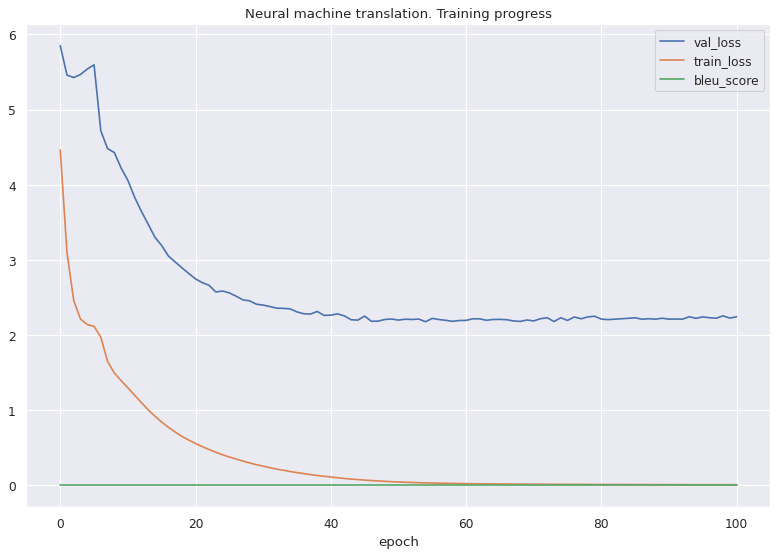

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import ast

with open("./baseline/progress_log.txt", 'r') as fread:
    stats = fread.readlines()
sns.lineplot
val_loss, train_loss, bleu_score = [], [], []
for i in range(1, len(stats)):
    stats[i] = ast.literal_eval(stats[i])
    val_loss.append(stats[i]['val_loss'])
    train_loss.append(stats[i]['train_loss'])
    bleu_score.append(stats[i]['bleu_score'])


sns.set_theme()
plt.figure(figsize=(12, 8), dpi=80)
sns.lineplot(np.arange(len(val_loss)), val_loss, label='val_loss')
sns.lineplot(np.arange(len(train_loss)), train_loss, label='train_loss')
sns.lineplot(np.arange(len(bleu_score)), bleu_score, label='bleu_score')
plt.xlabel('epoch')
plt.title('Neural machine translation. Training progress')
plt.legend()

## generate examples of translation

In [26]:
tmp_batch = next(iter(val_dataloader))
inp, tgt = tmp_batch[0][:10], tmp_batch[1][:10]
model.eval()
with torch.no_grad():
    out = model.generate(inp)
out.shape

for i in range(10):
    src_decoded = " ".join(data_manager.source_tokenizer.decode(inp[i].cpu().numpy().tolist()))
    out_decoded = " ".join(data_manager.target_tokenizer.decode(out[i].cpu().numpy().tolist()))
    tgt_decoded = " ".join(data_manager.target_tokenizer.decode(tgt[i].cpu().numpy().tolist()))
    print(f"{1 + i}.\tEN: {src_decoded}\n\tRU: {tgt_decoded}\n\tPRED: {out_decoded}")

1.	EN: he is still dependent on his parents
	RU: он все еще зависит от своих родителей
	PRED: будущем будущем что что что что что что что что что что что что что
2.	EN: he is older than she is by three years
	RU: он старше её на три года
	PRED: французскому чемпионка чемпионка чемпионка курса подозрений дежурит дежурит дежурит усер плохое животное ция крайности крайности
3.	EN: she s suffering from a serious dis ease
	RU: она страдает из за тяж ё ло го за боле вания
	PRED: ведь ведь большой большой большой большой большой большой большой большой большой большой большой большой большой
4.	EN: she s always finding fault with me
	RU: она постоянно ко мне придирается
	PRED: потерял делу пишет пишет пишет пишет пишет пишет пишет пишет пишет пишет пишет пишет пишет
5.	EN: he is always complaining about his low salary
	RU: он всегда жалуется на свою ни з ку ю за р пла ту
	PRED: забыла забыла говорят выгля бегунья бегунья нет нет нет нет нет нет нет нет нет
6.	EN: he is without qu est ion the 

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate schedualer/Adafactor with constant learning rate


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

input_ids = tokenizer("The <extra_id_0> walks in <extra_id_1> park", return_tensors="pt").input_ids
labels = tokenizer("<extra_id_0> cute dog <extra_id_1> the <extra_id_2>", return_tensors="pt").input_ids

# the forward function automatically creates the correct decoder_input_ids
loss = model(input_ids=input_ids, labels=labels).loss
loss.item()

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

input_ids = tokenizer("translate English to German: The house is wonderful.", return_tensors="pt").input_ids
labels = tokenizer("Das Haus ist wunderbar.", return_tensors="pt").input_ids

# the forward function automatically creates the correct decoder_input_ids
loss = model(input_ids=input_ids, labels=labels).loss
loss.item()